<a href="https://colab.research.google.com/github/fastforwardlabs/snorkel-demo-colab/blob/master/snorkel_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a text classification model using noisy regular expressions

In this notebook we will walk through a simple text classification problem that trains a complaint classifier using data from [Consumer Financial Protection Bureau](https://www.consumerfinance.gov/data-research/consumer-complaints/), showing how to use Snorkel for weak supervision.

## Setup

Installing Snorkel and other required libraries

In [1]:
!pip3 install -r requirements.txt
!pip3 install git+https://github.com/nishamuktewar/snorkel
!pip3 install treedlib
!pip3 install numbskull

  Cloning https://github.com/nishamuktewar/snorkel to /tmp/pip-req-build-fynpchmn
  Running command git clone -q https://github.com/nishamuktewar/snorkel /tmp/pip-req-build-fynpchmn
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3lajdz9/wheels/1c/dc/7b/9cf55b0576fad8e74e4e4c004231d1fd2814b01915d5582ba2
Successfully built snorkel


In [0]:
%load_ext autoreload
%autoreload 2

Disabling warning messages

In [0]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Loading necessary libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import os

from sklearn.model_selection import train_test_split
from collections import Counter
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass, Context, Candidate, StableLabel
from snorkel.contrib.models.text import RawText
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals
from snorkel.learning.tensorflow import TextRNN

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Download data, if it doesn't *exist*

In [0]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    !curl https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD > ./data/complaints.csv

## Preprocessing
Data load, filtering out irrelevant fields and rows. Each row in the final dataframe - complaints_df consists of a "complaint" field and an associated ground truth label = (1, -1). These ground truth labels are used to review the performance of the labeling process, afterall the whole idea is to do without any labeled data!

In [6]:
complaints = pd.read_csv(os.path.join(data_dir,'complaints.csv'))
complaints.info()
complaints.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322633 entries, 0 to 1322632
Data columns (total 18 columns):
Date received                   1322633 non-null object
Product                         1322633 non-null object
Sub-product                     1087467 non-null object
Issue                           1322633 non-null object
Sub-issue                       786560 non-null object
Consumer complaint narrative    393129 non-null object
Company public response         470468 non-null object
Company                         1322633 non-null object
State                           1301875 non-null object
ZIP code                        1201781 non-null object
Tags                            181027 non-null object
Consumer consent provided?      715628 non-null object
Submitted via                   1322633 non-null object
Date sent to company            1322633 non-null object
Company response to consumer    1322626 non-null object
Timely response?                1322633 non-null obj

(1322633, 18)

### Subset data to include products with narrative

In [0]:
products_w_narrative = complaints[complaints['Product'].notnull() & 
                                  complaints['Consumer complaint narrative'].notnull()]

In [8]:
print(products_w_narrative['Product'].unique())
print(products_w_narrative['Product'].value_counts())

['Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Credit card or prepaid card'
 'Payday loan, title loan, or personal loan' 'Mortgage' 'Student loan'
 'Money transfer, virtual currency, or money service'
 'Checking or savings account' 'Vehicle loan or lease' 'Credit card'
 'Bank account or service' 'Credit reporting' 'Consumer Loan'
 'Prepaid card' 'Payday loan' 'Money transfers' 'Other financial service'
 'Virtual currency']
Credit reporting, credit repair services, or other personal consumer reports    96556
Debt collection                                                                 88641
Mortgage                                                                        53776
Credit reporting                                                                31588
Credit card or prepaid card                                                     22389
Student loan                                                                    22240
Cred

### Selects two types of products - credit reporting and mortgage

In [0]:
# credit reporting only
credit_reporting = products_w_narrative[products_w_narrative['Product'] == 'Credit reporting, ' + 
                                 'credit repair services, or other personal consumer reports']
# mortgage only
mortgage = products_w_narrative[products_w_narrative['Product'] == 'Mortgage']

In [0]:
credit_narrative = credit_reporting['Consumer complaint narrative'].values
positive_labels = pd.Series(np.ones(credit_narrative.shape[0]))
positive_df = pd.DataFrame({'complaint': credit_narrative, 'label': positive_labels})

In [0]:
mortgage_narrative = mortgage['Consumer complaint narrative'].values
negative_labels = pd.Series(np.full(mortgage_narrative.shape[0], -1))
negative_df = pd.DataFrame({'complaint': mortgage_narrative, 'label': negative_labels})

### Combine into one dataframe, create labels 
(1 for credit reporting, -1 for mortgage)

In [12]:
complaints_df = pd.concat([positive_df, negative_df], ignore_index=True)
complaints_df.shape

(150332, 2)

In [13]:
complaints_df['label'].value_counts()

 1.0    96556
-1.0    53776
Name: label, dtype: int64

### Split data into train, dev, test

In [0]:
train, testval = train_test_split(complaints_df, test_size=0.2, random_state=123)
dev, test = train_test_split(testval, test_size=0.5, random_state=123)

## Create noisy labeling functions

Our assumption is that we don't have the ground truth labels for our data, but instead have these noisy and possibly conflicting labels based on regular expressions.

### Regular expressions that define words, phrases, actions for use in labeling functions

In [0]:
AGENCY_NAMES = r'\bexperian\b|\btransunion\b|\bequifax\b|\bfcra\b'   
DEBT_MENTIONS = r'\bcollector\b|\bdebt\b|\bcreditor\b'
ADDRESS_MENTIONS = r'\baddress\b'
DESCRIPTIONS = r'\binaccura|\bcompromise'
IDENTITY = r'\bidentity'
CREDIT_REPORT_MENTIONS = r'\bcredit (report|agency|reporting|bureau|agencies)'              
MORTGAGE_MENTIONS = r'\bloan\b|\bmortgage\|\bprepayment\b|\bprincipal\b|\binterest\b|\bescrow\b'
CHECKS = r'\bcheck'
TAXES = r'\btax'
LEASE = r'\blease'
HOUSE_MENTIONS = r'\bhouse\b|\bhome\bcondo\b'
MORTGAGE_HELP_ACTIONS = r'\bmitigat|\bmodifi\brefinanc'
MORTGAGE_COMPONENTS = r'\bequity\b|\bdownpayment\b|\bshortage\b'
POSITIVE_ACTIONS = r'\bremov|\bdispute\b' 
INQUIRY_ACTIONS  = r'\binquir\b|\berror\b'
NEGATIVE_ACTIONS = r'\bpredator|\bapprove|\bservic|\bappraise|\bforeclos'  
                                                                      
FRAUD = r'\bfraudulent (account|charges)'                                               
MONEYXFER = r'\bmoney transfer'                                                         
CREDIT_REPORTING = r'\b(identity has been compromise(|d)|data breaches|inquiries to bus\
inesses|mistakes appear in my report|reporting incorrectly|dispute(|d)|(t|T)ransunion|derog\
atory|experian|identity theft)'                                                             
CREDIT_REPAIR = r'\b(credit repair|hard inquiry|inquiries to businesses|mistakes appear\
 in my report|reporting incorrectly)'       

### Labeling functions that help provide weak supervision

In other words, instead of hand-labeling data to create a training set for our model, we write functions that look something like this:

In [0]:
def lf_agency_names(complaint):                                                                   
    if re.search(AGENCY_NAMES, str(complaint), re.IGNORECASE):                            
        return 1                                                                            
    else:                                                                                   
        return 0            

def lf_debt(complaint):                                                            
    if re.search(DEBT_MENTIONS, str(complaint), re.IGNORECASE):                           
        return 1                                                                            
    else:                                                                                   
        return 0      

def lf_address(complaint):                                                            
    if re.search(ADDRESS_MENTIONS, str(complaint), re.IGNORECASE):
        return 1                                                                            
    else:                                                                                   
        return 0     
    
def lf_credit_report(complaint):                                                           
    if re.search(CREDIT_REPORT_MENTIONS, str(complaint), re.IGNORECASE):                          
        return 1                                                                            
    else:                                                                                   
        return 0             
    
def lf_credit_actions(complaint):                                                           
    if re.search(POSITIVE_ACTIONS, str(complaint), re.IGNORECASE):                          
        return 1                                                                            
    else:                                                                                   
        return 0             
    
def lf_mortgage(complaint):                                                                 
    if re.search(MORTGAGE_MENTIONS, str(complaint), re.IGNORECASE):                            
        return -1                                                                           
    else:                                                                                   
        return 0        
    
def lf_inquiry(complaint):                                                                 
    if re.search(INQUIRY_ACTIONS, str(complaint), re.IGNORECASE):                            
        return 1                                                                           
    else:                                                                                   
        return 0        
    
def lf_house_mentions(complaint):                                                         
    if re.search(HOUSE_MENTIONS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0          
    
def lf_mortgage_help(complaint):                                                         
    if re.search(MORTGAGE_HELP_ACTIONS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0          
    
def lf_mortgage_components(complaint):                                                         
    if re.search(MORTGAGE_COMPONENTS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0          
    
def lf_fraud(complaint):                                                                    
    if (re.search(FRAUD, str(complaint), re.IGNORECASE)                                     
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                       
        return 1                                                                            
    elif (re.search(FRAUD, str(complaint), re.IGNORECASE)                                   
          and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                         
        return -1                                                                           
    else:                                                                                   
        return 0     
    
def lf_reporting(complaint):                                                                
    if (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)                          
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                       
        return 1                                                                            
    elif (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)                        
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):                        
        return -1                                                                           
    else:                                                                                   
        return 0     

def lf_repair(complaint):                                                                   
    if (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE)                             
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)                         
        and not re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)                  
       ):                                                                                   
        return 1                                                                            
    elif ((re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE)                          
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE))                         
          or                                                                                
          (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE)                          
           and re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE))                  
         ):                                                                                 
        return -1                                                                           
    else:                                                                                   
        return 0  

def lf_credit_description(complaint):                                                                
    if (re.search(DESCRIPTIONS, str(complaint), re.IGNORECASE)                          
        and re.search(IDENTITY, str(complaint), re.IGNORECASE)):                       
        return 1                                                                                                                                             
    else:                                                                                   
        return 0           
    
def lf_description_not_mortgage(complaint):                                                                
    if (re.search(DESCRIPTIONS, str(complaint), re.IGNORECASE)                          
        and not re.search(MORTGAGE_MENTIONS, str(complaint), re.IGNORECASE)):                       
        return 1                                                                                                                                             
    else:                                                                                   
        return 0           
    
def lf_tax(complaint):                                                         
    if re.search(TAXES, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0    
    
def lf_check(complaint):                                                         
    if re.search(CHECKS, str(complaint), re.IGNORECASE):                          
        return -1                                                                           
    else:                                                                                   
        return 0    
    
def lf_lease(complaint):                                                         
    if re.search(LEASE, str(complaint), re.IGNORECASE):                          
        return 1                                                                          
    else:                                                                                   
        return 0    

## Generate Snorkel objects

### Candidates

Candidate objects in Snorkel represent objects to be classified. In this case we are interested in classifying whether a narrative is positive -that is credit related or not.

In [18]:
session = SnorkelSession()

values = list(complaints_df.label.unique())
print(values)

# snorkel candidate, value if none defaults to binary (true, false)
Narrative = candidate_subclass('Narrative', ['narrative'], values=values)

# Make sure DB is cleared
session.query(Context).delete()
session.query(Candidate).delete()
session.query(StableLabel).delete()

[1.0, -1.0]


0

### Contexts

All Candidate objects point to one or more Context objects representing the raw data that they are rooted in. In this case, our candidates will each point to a single Context object representing the raw text of the complaint.

Once we have defined the Context for each Candidate, we can commit them to the database. Note that we also split into three sets while doing this:

- Training set (split=0): The narratives for which we have noisy, conflicting labels from our labeling functions; we will resolve these conflicts using the GenerativeModel and then use them as training data for the RNN
- Development set (split=1): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and use these to test the RNN's performance on unseen data
- Test set (split=2): We will pretend that we do not have any noisy, conflicting labels for this split of the data, and use these to test the RNN's performance on unseen data   

In [19]:
train_index = train.index
train.index.str = np.asarray(str(x) for x in train.index)
train_complaints = train.values[:, 0]
train_labels = train.values[:, 1]

for element in zip(train_index, train_complaints, train_labels):
    split = 0
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)

dev_index = dev.index
dev.index.str = np.asarray(str(x) for x in dev.index)
dev_complaints = dev.values[:, 0]
dev_labels = dev.values[:, 1]

for element in zip(dev_index, dev_complaints, dev_labels):
    split = 1
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)

test_index = test.index
test.index.str = np.asarray(str(x) for x in test.index)
test_complaints = test.values[:, 0]
test_labels = test.values[:, 1]

for element in zip(test_index, test_complaints, test_labels):
    split = 2
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)

session.commit()

# number of datapoints
print("number of datapoints in candidate: ", session.query(Narrative).count())
# load ground truth labels
train_cand_labels = train_labels
dev_cand_labels = dev_labels
test_cand_labels = test_labels

number of datapoints in candidate:  150332


In [20]:
# test one labeling function
labeled = []
for c in session.query(Narrative).filter(Narrative.split == 1).all():
    if lf_tax(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

Number labeled: 904


### Labels

Next, we assign labeling functions for each of the training candidates in a sparse matrix (which will also automatically be saved to the Snorkel database), with one row for each candidate and one column for each label

In [21]:
LFs = [lf_agency_names, lf_debt, lf_address, lf_credit_report, lf_credit_actions, 
       lf_inquiry, lf_mortgage, lf_house_mentions, lf_mortgage_components,
       lf_mortgage_help, lf_fraud, lf_reporting, lf_repair,
       lf_credit_description, lf_description_not_mortgage,
       lf_tax, lf_check, lf_lease]
# apply labeling functions
labeler = LabelAnnotator(lfs = LFs)
L_train = labeler.apply(split=0)

  0%|          | 18/120265 [00:00<11:22, 176.12it/s]

Clearing existing...
Running UDF...


100%|██████████| 120265/120265 [10:20<00:00, 193.78it/s]


In [22]:
# see what's going on
print(L_train.get_candidate(session, 0))
print(L_train.get_key(session, 0))
print(L_train.lf_stats(session))


Narrative(Raw Text I had a XXXX XXXX card back in XXXX. I set up the account via their phone service after starting the card in store. When I went to pay a bill, the sum initially showed deducted from my checking account and then reappeared after a few weeks. It turned out, the XXXX XXXX  representative. Seeing as this was their error, they corrected the information and removed the late fee. 

Now, just over 2 years later, I am attempting to by a home and that error ( which XXXX XXXX  said was being removed ) is still on my credit record. I even closed that account over a year ago. 

I would like this error removed from my credit history, not just a late fee removed.)
LabelKey (lf_agency_names)
                              j  Coverage  Overlaps  Conflicts
lf_agency_names               0  0.280148  0.262096   0.062121
lf_debt                       1  0.144631  0.137264   0.057456
lf_address                    2  0.099173  0.093818   0.046905
lf_credit_report              3  0.438548  0

## Training generative model


The problem with the above labeling functions is that they're noisy, conflicting and may even overlap on certain examples. The key technical idea of Snorkel's generative modeling approach is that we can automatically model and denoise them!

In [23]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=20, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


## Applying the generative model


### Probabilistic Label Statistics

We view the distribution of weak labels produced by our generative model. Note that the samples in the 0.5 bucket indicate the ones that have no LF coverage.

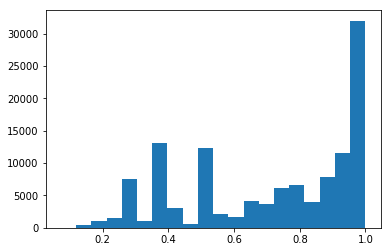

In [24]:
train_marginals = gen_model.marginals(L_train)
plt.hist(train_marginals, bins=20)
plt.show()

In [25]:
print("So we have ", (train_marginals == 0.5).sum(), " samples where the LFs do not provide any coverage!")

So we have  10658  samples where the LFs do not provide any coverage!


In [26]:
train_marginals.shape[0]

120265

In [27]:
(train_marginals == 0.5).sum()

10658

### Compare learned accuracies vs empirical accuracies

#### Learned accuracies from our generative model

In [28]:
accuracy = gen_model.score(L_train, train_cand_labels)
print("precision: {:.5f}".format(accuracy[0]), 
      "recall: {:.5f}".format(accuracy[1]), 
      "F-beta: {:.5f}".format(accuracy[2]))

precision: 0.86024 recall: 0.90166 F-beta: 0.88047


#### Empirical accuracies of our labeling functions - majority vote

We observe that the majority vote approach does almost as well as teh generative model for our use case!

In [29]:
# Collect the majority vote answer for each complaint
mv = []
for i in range(L_train.shape[0]):
    if np.diff(L_train[i].indptr) != 0:   #indicates that there is no coverage for a particular datapoint
        c = Counter([L_train[i,j] for j in L_train[i].nonzero()[1]])
        mv.append(c.most_common(1)[0][0])
    else:
        mv.append(0) # assume that no label is equivalent to a negative example
mv = np.array(mv)

# Count the number correct by majority vote
n_correct = np.sum([1 for i in range(L_train.shape[0]) if mv[i] == train_cand_labels[i]])
print ("Accuracy:{}".format(n_correct / float(L_train.shape[0])))
print ("Number incorrect:{}".format(L_train.shape[0] - n_correct))

# Compute and return precision, recall
tp = (0.5 * (mv * train_cand_labels + 1))[mv == 1].sum()
pred_pos = mv[mv == 1].sum()
p = tp / float(pred_pos) if pred_pos > 0 else 0.0
pos = train_cand_labels[train_cand_labels == 1].sum()
r = tp / float(pos) if pos > 0 else 0.0

# Compute general F-beta score
beta=1
if p + r > 0:
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r))
else:
    f_beta = 0.0

print("precision: {:.5f}".format(p), 
      "recall: {:.5f}".format(r), 
      "F-beta: {:.5f}".format(f_beta))


Accuracy:0.8077911279258304
Number incorrect:23116
precision: 0.87489 recall: 0.89429 F-beta: 0.88448


#### Performance on dev set
We can also get a more detailed score (true positives, false positives, true negatives, false negatives) on the dev set

In [30]:
L_dev = labeler.apply(split=1)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_cand_labels)

Clearing existing...


  0%|          | 20/15033 [00:00<01:16, 195.65it/s]

Running UDF...


100%|██████████| 15033/15033 [01:19<00:00, 189.82it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.906
Neg. class accuracy: 0.735
Precision            0.865
Recall               0.906
F1                   0.885
----------------------------------------
TP: 8874 | FP: 1390 | TN: 3849 | FN: 920



Saving the predictions of the generative model on the train set back to the database for future use

In [31]:
save_marginals(session, L_train, train_marginals)

Saved 120265 marginals


## Training a *noise-aware* discriminative model

In this step we set up a noise-aware discriminative model in TensorFlow and see how close we come to the fully supervised version!

### First, load the candidates

In [0]:
train_cands = session.query(Narrative).filter(Narrative.split == 0).order_by(Narrative.id).all()
dev_cands   = session.query(Narrative).filter(Narrative.split == 1).order_by(Narrative.id).all()
test_cands  = session.query(Narrative).filter(Narrative.split == 2).order_by(Narrative.id).all()


### Train model using RNN

We decided to leverage Snorkel's built-in discriminative classifier and made some custom changes to work with our example. 

Note, how the number of training samples below are lower than what's present in the training set, it excludes samples where there was no LF coverage, that is it trains on train_marginals.shape[0] - (train_marginals == 0.5).sum() samples

In [33]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.2,
    'print_freq': 1,
    'seed': 123,
    'batch_size': 200,
    'max_sentence_length': 512,
    'vocab_size': 5000
}

lstm = TextRNN(seed=123, cardinality=Narrative.cardinality)
# Note: Y_train are the marginals but Y_dev are the gold/ ground truth labels
lstm.train(X_train=train_cands, Y_train=train_marginals, X_dev=dev_cands, Y_dev=dev_cand_labels, **train_kwargs)

max sentence len in training data:  5729
but capped to:  512
And also curtailing warning(s) related to checking individual max sentence lengths in each narrative
currrent vocab size is:  170119
but capped to:  5000
[TextRNN] Training model
[TextRNN] n_train=109607  #epochs=10  batch size=200
[TextRNN] Epoch 0 (734.95s)	Average loss=0.452717	Dev F1=91.51
[TextRNN] Epoch 1 (1521.33s)	Average loss=0.418340	Dev F1=90.84
[TextRNN] Epoch 2 (2303.49s)	Average loss=0.414675	Dev F1=91.47
[TextRNN] Epoch 3 (3088.63s)	Average loss=0.414036	Dev F1=90.84
[TextRNN] Epoch 4 (3877.68s)	Average loss=0.412990	Dev F1=90.55
[TextRNN] Epoch 5 (4669.39s)	Average loss=0.412118	Dev F1=90.63
[TextRNN] Epoch 6 (5463.23s)	Average loss=0.412559	Dev F1=90.07
[TextRNN] Epoch 7 (6256.32s)	Average loss=0.412446	Dev F1=90.43
[TextRNN] Epoch 8 (7048.42s)	Average loss=0.411614	Dev F1=90.70
[TextRNN] Model saved as <TextRNN>
[TextRNN] Epoch 9 (7842.36s)	Average loss=0.412075	Dev F1=90.89
[TextRNN] Model saved as <TextRNN

### Accuracies on dev and test datasets

In [34]:
accuracy_dev = lstm.score(dev_cands, dev_cand_labels, batch_size=200)
print("precision: {:.5f}".format(accuracy_dev[0]), 
      "recall: {:.5f}".format(accuracy_dev[1]), 
      "F-beta: {:.5f}".format(accuracy_dev[2]))

precision: 0.85984 recall: 0.96396 F-beta: 0.90892


In [35]:
accuracy_test = lstm.score(test_cands, test_cand_labels, batch_size=200)
print("precision: {:.5f}".format(accuracy_test[0]), 
      "recall: {:.5f}".format(accuracy_test[1]), 
      "F-beta: {:.5f}".format(accuracy_test[2]))

precision: 0.85925 recall: 0.96318 F-beta: 0.90825
